# Analyzing the Price of Anarchy with selfish routing strategies

Under the (strong assumption) of equally distributed payment pairs on the Lightning Network we assume with a global coordinator to hardly observe payment failures (which result from channel depletion (which results from drain))

Thus the price of anarchy can be defined as the Area above the curve (Usually we have the area under the curve which will work if we focus on drain values from 0 to 0.5) We start from 0.5 to 1 as higher drain is higher failure rate and the distribution is symmetrical anyway.

## todos: 
* transfer drain to to failure rate distribution
* test globally optimal coordinated and see if that has really a CDF that jumps to 1 at a drain of 0.5 directly.
* introduce different prior that has expected drain 
* redifine price of anarchy as the area between the curves? Or don't do the area thing and just use a comparison of average values

## Acknowlegements
This notebook was creted by Rene Pickhardt and is a result of very helpful discussions with Krystal Maughan and Sebastian Alscher who are Rene's mentees during the 2022 Summer of Bitcoin. We expect this to be extended to a mathematically more sound theoretical and emperical work during the Summer of Bitcoin 2022.

The research of Rene Pickhardt is funded through NTNU & BitMEX and various doners at https://donation.rene-pickhardt.de and https://www.patreon.com/renepickhardt While the mentees are sponsored by Summer of Bitcoin.

In [127]:
import networkx as nx
import json
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt

from pickhardtpayments import ChannelFields
from math import log2 as log


## Data Import

We import the graph to networkx and append various properties that can be used as selfish routing strategies of sending nodes

* fee = minimize for `ppm`
* reliability = minimize the linearized uncertainty cost which is `1/capacity`
* cln = an approximation to CLN cost function (c.f.: https://github.com/ElementsProject/lightning/pull/4771 )
* feature_engineering = most selfish strategy from feature engineering and pruning at optimally reliable payment flows (c.f.: https://github.com/renepickhardt/mpp-splitter/issues/12) 

In [110]:
with open("listchannels20220412.json") as f:
    channels = json.load(f)["channels"]
G = nx.MultiDiGraph()
combined_costs = []
for channel in channels:
    src = channel[ChannelFields.SRC]
    dest = channel[ChannelFields.DEST]
    ppm = channel[ChannelFields.FEE_RATE]
    linearized_uncertainty_unit_cost = 1.0/float(channel[ChannelFields.CAP])

    #following: https://github.com/renepickhardt/mpp-splitter/issues/12
    combined_cost = log(1_500_000_000*linearized_uncertainty_unit_cost) + 1.6*log(ppm+1)
    cln = linearized_uncertainty_unit_cost*(ppm+1)/(linearized_uncertainty_unit_cost+ppm+1)
    
    #selfish_strategies=["fee","reliability","cln","feature_engineering"]
    G.add_edge(src,dest,fee=ppm,reliability=linearized_uncertainty_unit_cost,cln=cln,feature_engineering=combined_cost)
    combined_costs.append(combined_cost)

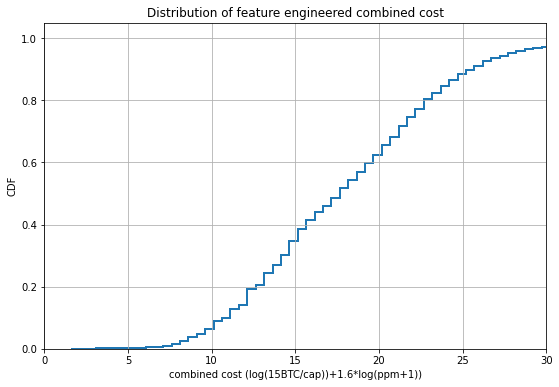

In [113]:
# sanity check make sure the feature engineered combined cost is the same as observed elsewhere 
plt.figure(figsize=(9,6))
plt.title("Distribution of feature engineered combined cost")
plt.hist(combined_costs,density=True, cumulative=True,bins=120, histtype="step",linewidth=2)
plt.xlabel("combined cost (log(15BTC/cap))+1.6*log(ppm+1))")
plt.grid()
plt.xlim(0,30)
plt.ylabel("CDF")
plt.show()


## Cound statistics for the price of anarcy

We compute for all pairwise shortest paths (according to a `selfish_strategy`) and count how often we visit a channel in each direction. Actually here we look at a node pair and ignore parallel channels. From those frequencies we compute the drain that we expect for each channel on the network. The drain thus results from statistical analysis of gossip and the selfish strategy. We return a list of all expected drain values. Note that a channel in direction A-->B having drain of x will result in the channel of direction B--->A having drain 1-x. Thus this distribution is symmetrical around 0.5 and can just be filtered. We decide to take the parts from 0.5 to 1 as higher drain values will result in higher failure rates

In [115]:
def next_hop(path):
    for i in range(1,len(path)):
        yield (path[i-1],path[i])

In [161]:
def compute_drains(G,selfish_strategy):
    nodes = set(G.nodes())
    frequencies = {}
    for k,n in enumerate(G.nodes()):
        _, res = nx.single_source_dijkstra(G,n, weight=selfish_strategy)

        for key, path in res.items():
            for src, dest in next_hop(path):
                if src in frequencies:
                    if dest in frequencies[src]:
                        frequencies[src][dest]+=1
                    else:
                        frequencies[src][dest]=1
                else:
                    frequencies[src]={dest:1}
        #if k % 100==0:
        #    print(k)

    drains = []
    for k,n in enumerate(nodes):
        for m in nodes:
            try:
                total_usage = frequencies[n][m]+frequencies[m][n]
                drain = 0
                if total_usage > 0:
                    drain = frequencies[n][m]/total_usage
                drains.append(drain)
            except:
                pass
    #if k%250 == 0:
    #    print(k)
    
    filtered = [d for d in drains if d >=0.5]
    return frequencies, drains, filtered

In [164]:
"""
commented out as runtime is really long
selfish_strategies=["fee","reliability","cln","feature_engineering"]
for strategy in selfish_strategies:
    frequencies, drains, filtered = compute_drains(G,strategy)
    #pickle.dump( drains, open( "selfish_{}_drains.p".format(strategy), "wb" ) )
    #pickle.dump( filtered, open( "selfish_{}_filtered_drains.p".format(strategy), "wb" ) )
    #pickle.dump( frequencies, open( "selfish_{}_frequencies.p".format(strategy), "wb" ) )
"""


## Visualize the distribtion of expected drains from various Selfish behavior

In [165]:
#load from hard disk for quicker visualization
# FIXME: might have different filenames
fee = pickle.load( open( "selfish_fee_filtered_drains.p", "rb" ) )
reliable = pickle.load( open( "selfish_reliability_filtered_drains.p", "rb" ) )
cln = pickle.load( open( "selfish_cln_filtered_drains.p", "rb" ) )
feature_engineered = pickle.load( open( "selfish_feature_engineering_filtered_drains.p", "rb" ) )

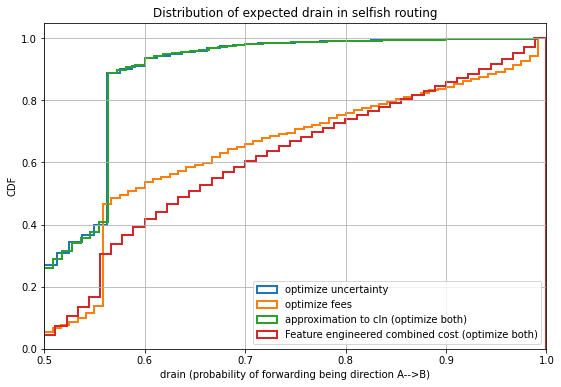

In [166]:
plt.figure(figsize=(9,6))
plt.title("Distribution of expected drain in selfish routing")
#disturbing bin sizses a bit so that the curves are easier to read when they share a lot of values
plt.hist(reliable,density=True, cumulative=True,bins=40, histtype="step",linewidth=2, label="optimize uncertainty")
plt.hist(fee,density=True, cumulative=True,bins=60, histtype="step",linewidth=2,label="optimize fees")
plt.hist(cln,density=True, cumulative=True,bins=55, histtype="step",linewidth=2,label="approximation to cln (optimize both)")
plt.hist(feature_engineered,density=True, cumulative=True,bins=45, histtype="step",linewidth=2,label="Feature engineered combined cost (optimize both)")

plt.xlabel("drain (probability of forwarding being direction A-->B)")
plt.ylabel("CDF")
plt.legend(loc="lower right")
plt.xlim(0.5,1.0)
plt.grid()
plt.savefig("Price of Anarchy")
plt.show()


## Channel Depletion Model

This explains how `failure rate` of using the `channel` (in a random `direction`) can be predicted from the `drain` of `payment flows` through the `channel`. This is what we call the `channel depleteion model`

In [143]:
def do_simulation(a,b,p,random_amt = None):
    suc = 0 
    fail = 0
    attempt = 0
    cap = a + b
    N = 500_000
    
    failure_rate = []

    for i in range(N):
        amt = 1
        if random_amt is not None:
            # FIXME: add random sampling from ZIPF distribution and not only uniform
            amt = max(1,random.randint(0,max(1,int(cap*random_amt/100))))
        attempt += 1
        # a(lice) pays
        if random.random()<p:
            if a - amt >=0:
                a = a - amt
                b = b + amt
                suc +=1
            else: 
                fail +=1
        else:
            if b - amt >=0:
                b = b - amt
                a = a + amt
                suc +=1
            else:
                fail +=1
        failure_rate.append(float(fail)/attempt)
    return failure_rate

In [139]:
drain_channel = []
failure_rate_small_channel = []
for i in range(0,101):
    p = 0.01*i
    a = 5
    b = 5
    fr = do_simulation(a,b,p)
    m = np.mean(fr[:-10_000])
    drain_channel.append(p)
    failure_rate_small_channel.append(m)
    


In [140]:
failure_rate_large_channel = []
for i in range(0,101):
    p = 0.01*i
    a = 50
    b = 50
    fr = do_simulation(a,b,p)
    m = np.mean(fr[:-10_000])
    failure_rate_large_channel.append(m)

In [146]:
failure_rate_large_channel_random_amount = []
for i in range(0,101):
    p = 0.01*i
    a = 50
    b = 50
    fr = do_simulation(a,b,p,20)
    m = np.mean(fr[:-10_000])
    failure_rate_large_channel_random_amount.append(m)

In [147]:
failure_rate_large_channel_random_large_amounts = []
for i in range(0,101):
    p = 0.01*i
    a = 50
    b = 50
    fr = do_simulation(a,b,p,80)
    m = np.mean(fr[:-10_000])
    failure_rate_large_channel_random_large_amounts.append(m)

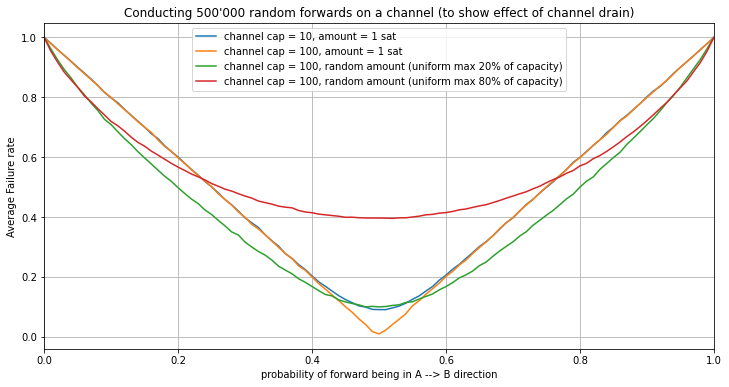

In [148]:
plt.figure(figsize=(12,6))
plt.title("Conducting 500'000 random forwards on a channel (to show effect of channel drain)")
plt.plot(drain_channel, failure_rate_small_channel, label="channel cap = 10, amount = 1 sat")
plt.plot(drain_channel, failure_rate_large_channel, label= "channel cap = 100, amount = 1 sat")
plt.plot(drain_channel, failure_rate_large_channel_random_amount, label= "channel cap = 100, random amount (uniform max 20% of capacity)")
plt.plot(drain_channel, failure_rate_large_channel_random_large_amounts, label= "channel cap = 100, random amount (uniform max 80% of capacity)")
plt.xlabel("probability of forward being in A --> B direction")
plt.ylabel("Average Failure rate")
plt.xlim(0,1)
plt.legend(loc="upper center")
plt.grid()
plt.show()

### Depicting the failurerate from the bounded random walk

We want to depict how the random walk of a single config for drain looks like and visually show how the expected failure rate seems to become stationary. thus for various drain values we depict the time series and not only the average of the last couple elements

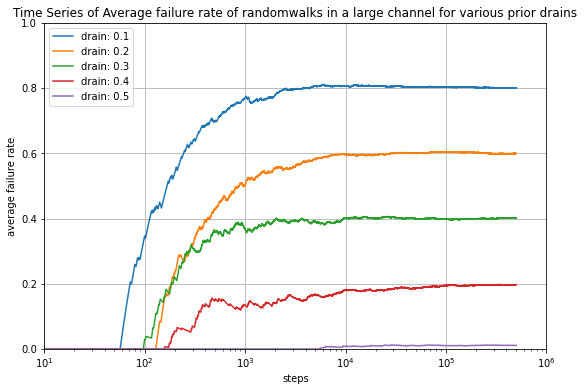

In [158]:
drains = [0.1,0.2,0.3,0.4,0.5]
steps = list(range(500_000))
plt.figure(figsize=(9,6))
plt.title("Time Series of Average failure rate of randomwalks in a large channel for various prior drains")
for drain in drains:
    fr = do_simulation(50,50,drain)
    plt.plot(steps, fr, label = "drain: {:3.1f}".format(drain))

plt.grid()
plt.legend()
plt.xscale("log")
plt.xlim(10,1000_000)
plt.ylim(0,1)
plt.ylabel("average failure rate")
plt.xlabel("steps")
plt.show()

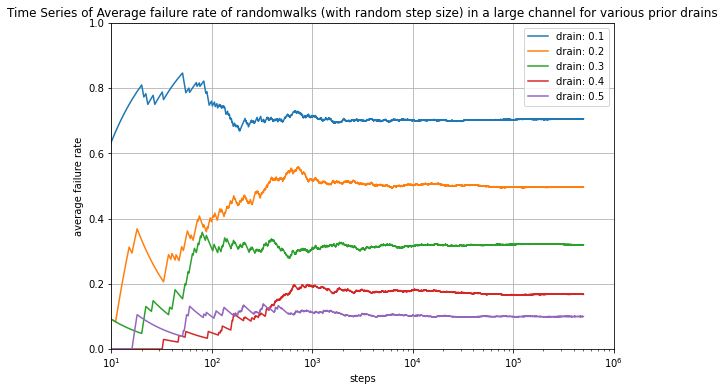

In [159]:
drains = [0.1,0.2,0.3,0.4,0.5]
steps = list(range(500_000))
plt.figure(figsize=(9,6))
plt.title("Time Series of Average failure rate of randomwalks (with random step size) in a large channel for various prior drains")
for drain in drains:
    fr = do_simulation(50,50,drain,20)
    plt.plot(steps, fr, label = "drain: {:3.1f}".format(drain))

plt.grid()
plt.legend()
plt.xscale("log")
plt.xlim(10,1000_000)
plt.ylim(0,1)
plt.ylabel("average failure rate")
plt.xlabel("steps")
plt.show()